In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
db_user = 'postgres'
db_password = 'postgres' # ¡Reemplaza con tu contraseña!
db_host = 'localhost'
db_port = '5432'
db_name = 'examen'
schema = 'memsch'

try:
    engine = create_engine(
        f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'
    )
    print("Connectado.")
except Exception as e:
    print(f"Error: {e}")

Connectado.


<b> 1. Graficar la evolución del precio MDA y MTR del nodo 01ANS-85

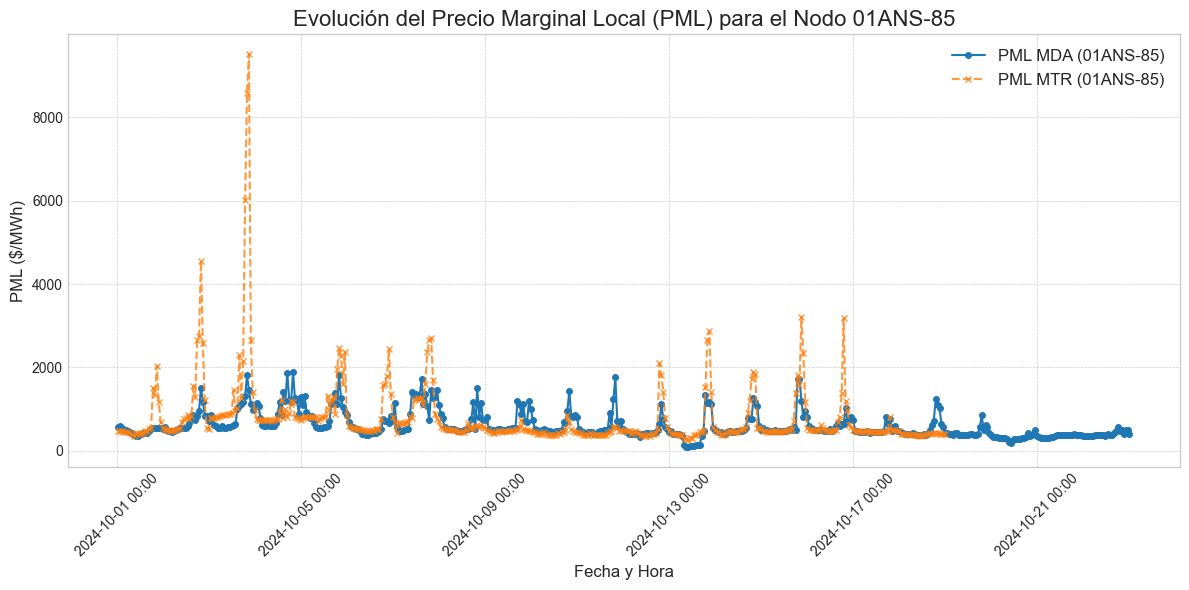

In [ ]:
nodo= '01ANS-85'

df_mda = pd.read_sql_table('memtramdadet', engine, schema=schema)
df_mda= df_mda[df_mda['clanodo'] == nodo]
df_mda['datetime'] = pd.to_datetime(df_mda['fecha']) + pd.to_timedelta(df_mda['hora'], unit='h')

df_mtr = pd.read_sql_table('memtramtrdet', engine, schema=schema)
df_mtr = df_mtr[df_mtr['clanodo'] == nodo]
df_mtr['datetime'] = pd.to_datetime(df_mtr['fecha']) + pd.to_timedelta(df_mtr['hora'], unit='h')

plt.style.use('seaborn-v0_8-whitegrid') # Estilo de la gráfica
fig, ax = plt.subplots(figsize=(12, 6)) # Tamaño de la figura

# Datos
ax.plot(df_mda['datetime'], df_mda['pml'], label=f'PML MDA ({nodo})', marker='o', linestyle='-', markersize=4)
ax.plot(df_mtr['datetime'], df_mtr['pml'], label=f'PML MTR ({nodo})', marker='x', linestyle='--', markersize=4, alpha=0.8)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# Títulos y etiquetas
ax.set_title(f'Evolución del Precio Marginal Local (PML) para el Nodo {nodo}', fontsize=16)
ax.set_xlabel('Fecha y Hora', fontsize=12)
ax.set_ylabel('PML ($/MWh)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

<b> 2. Grafícar la diferencia promedio por día del precio entre el MDA y MTR de todos los nodos agrupados por día

   - Barra Verde: El precio promedio en MTR fue MÁS ALTO que en MDA.
   - Barra Roja: El precio promedio en MTR fue MÁS BAJO que en MDA.


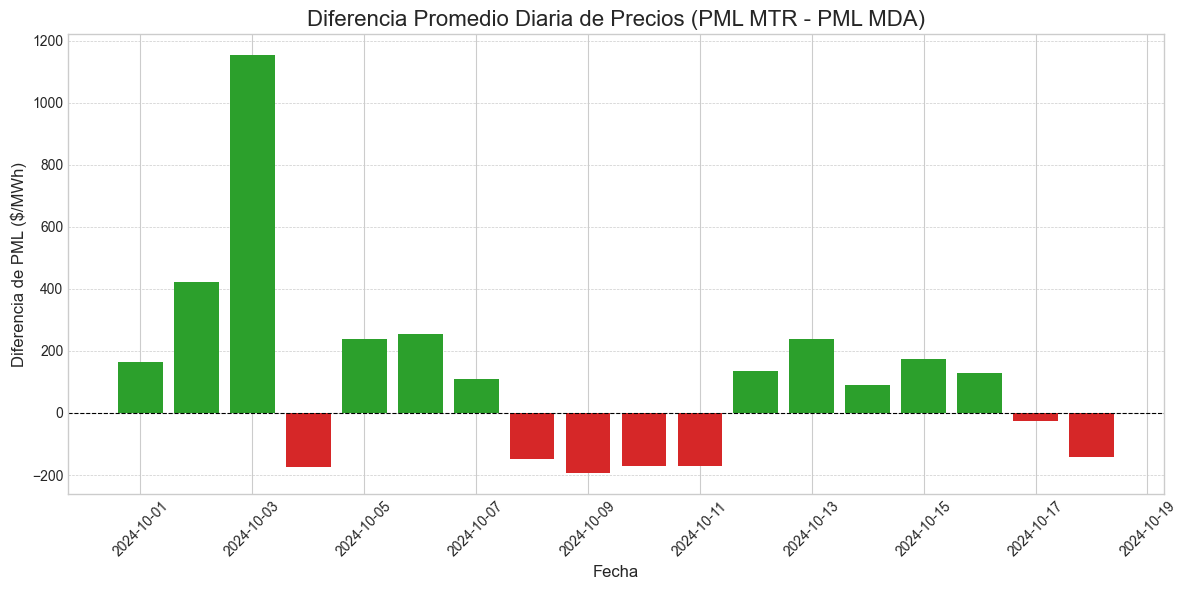

In [ ]:
df_mda['origen'] = 'MDA'
df_mtr['origen'] = 'MTR'
df_mda_mtr = pd.concat([df_mda, df_mtr], ignore_index=True)
df_mda_mtr['fecha'] = pd.to_datetime(df_mda_mtr['fecha'])

df_diferencia = df_mda_mtr.groupby(['fecha', 'origen'])['pml'].mean().unstack()
df_diferencia['diff_mtr_mda'] = df_diferencia['MTR'] - df_diferencia['MDA']

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

colores = ['#2ca02c' if x > 0 else '#d62728' for x in df_diferencia['diff_mtr_mda']]

ax.bar(df_diferencia.index, df_diferencia['diff_mtr_mda'], color=colores, width=0.8)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)

# Títulos y etiquetas
ax.set_title('Diferencia Promedio Diaria de Precios (PML MTR - PML MDA)', fontsize=16)
ax.set_ylabel('Diferencia de PML ($/MWh)', fontsize=12)
ax.set_xlabel('Fecha', fontsize=12)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

print("   - Barra Verde: El precio promedio en MTR fue MÁS ALTO que en MDA.")
print("   - Barra Roja: El precio promedio en MTR fue MÁS BAJO que en MDA.")

plt.tight_layout()
plt.show()

<b> 3. Une en una sola tabla MemTraMdaDet y MemTraMtrDet agregando una columna al inicio que se llame origen y pueda ser “MDA” o “MTR”

In [5]:
df_mda = pd.read_sql_table('memtramdadet', engine, schema=schema)
df_mtr = pd.read_sql_table('memtramtrdet', engine, schema=schema)

df_mda['origen'] = 'MDA'
df_mtr['origen'] = 'MTR'

df_mda_mtr = pd.concat([df_mda, df_mtr], ignore_index=True)
df_mda_mtr = df_mda_mtr[['origen'] + df_mda_mtr.columns[df_mda_mtr.columns != 'origen'].tolist()]

df_mda_mtr.head()

,origen,idmda,clanodo,fecha,hora,pml,pml_ene,pml_per,pml_cng,fechaultimamod,nombrepcmod,clausuariomod,idmtr
0,MDA,1.0,01ALR-85,2024-10-01,1,557.13,528.92,28.11,0.10,NaT,None,None,NaN
1,MDA,2.0,01AMM-230,2024-10-01,1,529.73,528.92,1.23,-0.42,NaT,None,None,NaN
2,MDA,3.0,01AMO-85,2024-10-01,1,563.57,528.92,34.60,0.06,NaT,None,None,NaN
3,MDA,4.0,01ANL-85,2024-10-01,1,556.34,528.92,27.27,0.16,NaT,None,None,NaN
4,MDA,5.0,01ANM-115,2024-10-01,1,548.14,528.92,19.37,-0.14,NaT,None,None,NaN


<b> 4. Une esta tabla creada en el paso anterior y la de TC, para agregar a una columna de valor para tener tambien el tc

In [6]:
df_tc = pd.read_sql_table('memtratcdet', engine, schema=schema)

df_tc = df_tc[['fecha', 'valor']]
df_tc.rename(columns={'valor': 'tipo_cambio'}, inplace=True)

df_mda_mtr_tc = pd.merge(df_mda_mtr, df_tc, on='fecha', how='left')

df_mda_mtr_tc.head()

,origen,idmda,clanodo,fecha,hora,pml,pml_ene,pml_per,pml_cng,fechaultimamod,nombrepcmod,clausuariomod,idmtr,tipo_cambio
0,MDA,1.0,01ALR-85,2024-10-01,1,557.13,528.92,28.11,0.10,NaT,None,None,NaN,19.6697
1,MDA,2.0,01AMM-230,2024-10-01,1,529.73,528.92,1.23,-0.42,NaT,None,None,NaN,19.6697
2,MDA,3.0,01AMO-85,2024-10-01,1,563.57,528.92,34.60,0.06,NaT,None,None,NaN,19.6697
3,MDA,4.0,01ANL-85,2024-10-01,1,556.34,528.92,27.27,0.16,NaT,None,None,NaN,19.6697
4,MDA,5.0,01ANM-115,2024-10-01,1,548.14,528.92,19.37,-0.14,NaT,None,None,NaN,19.6697


<b> 5.	Genera un DataFrame Nodo,fecha,hora,pml,tbfin de los datos que el pml sea mayor que la tbfin

In [7]:
df_mda = pd.read_sql_table('memtramdadet', engine, schema=schema)
df_mtr = pd.read_sql_table('memtramtrdet', engine, schema=schema)
df_tbfin = pd.read_sql_table('memtratbfinvw', engine, schema=schema)

df_mda_mtr = pd.concat([df_mda, df_mtr], ignore_index=True)

df_mda_mtr['fecha'] = pd.to_datetime(df_mda_mtr['fecha'])
df_tbfin['fecha'] = pd.to_datetime(df_tbfin['fecha'])

df_mda_mtr_tbfin = pd.merge(df_mda_mtr, df_tbfin, on='fecha', how='left')

df_pml_hi_tbfin = df_mda_mtr_tbfin[df_mda_mtr_tbfin['pml'] > df_mda_mtr_tbfin['tbfin']][['clanodo', 'fecha', 'hora', 'pml', 'tbfin']]

df_pml_hi_tbfin.head()

,clanodo,fecha,hora,pml,tbfin
0,01ALR-85,2024-10-01,1,557.13,449.792535
1,01AMM-230,2024-10-01,1,529.73,449.792535
2,01AMO-85,2024-10-01,1,563.57,449.792535
3,01ANL-85,2024-10-01,1,556.34,449.792535
4,01ANM-115,2024-10-01,1,548.14,449.792535


<b> 6.	Genera un dataframe que tenga el promedio diario de los precios del pml

In [8]:
df_mda = pd.read_sql_table('memtramdadet', engine, schema=schema)
df_mtr = pd.read_sql_table('memtramtrdet', engine, schema=schema)

df_precios = pd.concat([df_mda, df_mtr], ignore_index=True)

df_promedio_diario = df_precios.groupby('fecha')['pml'].mean().reset_index()
df_promedio_diario.rename(columns={'pml': 'pml_promedio_diario'}, inplace=True)

df_promedio_diario.head()

,fecha,pml_promedio_diario
0,2024-10-01,476.506683
1,2024-10-02,777.684688
2,2024-10-03,1277.667856
3,2024-10-04,812.140263
4,2024-10-05,902.049666


<b>7.	Grafica el precio del Nodo y el precio de la tbfin por fecha y hora

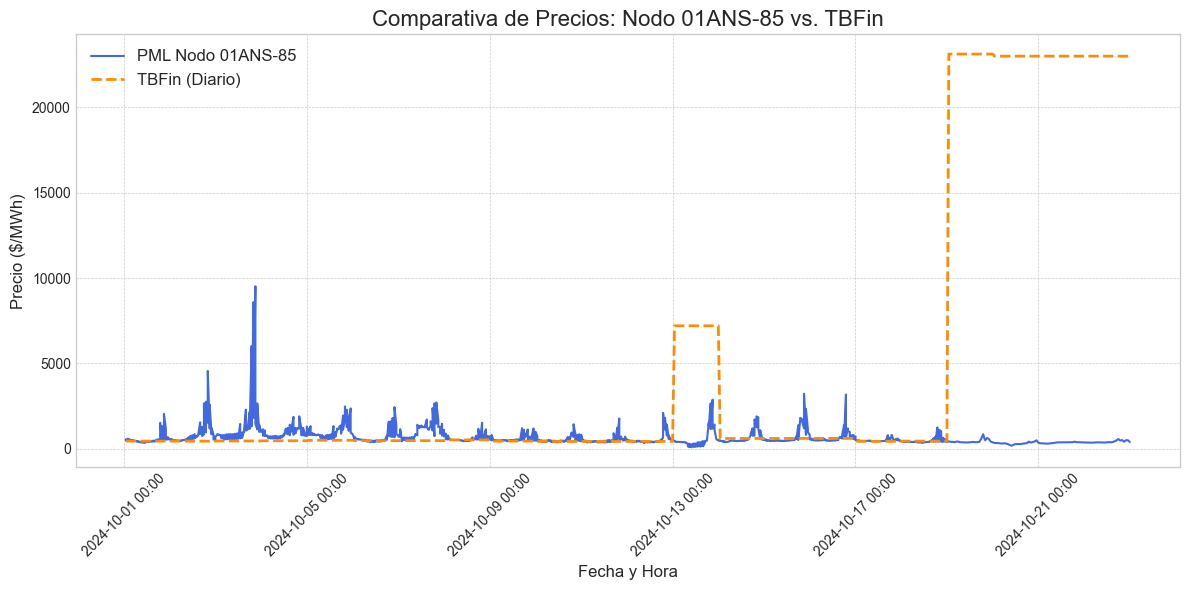

In [9]:
df_mda = pd.read_sql_table('memtramdadet', engine, schema=schema)
df_mtr = pd.read_sql_table('memtramtrdet', engine, schema=schema)
df_tbfin = pd.read_sql_table('memtratbfinvw', engine, schema=schema)

df_precios = pd.concat([df_mda, df_mtr], ignore_index=True)

df_precios['fecha'] = pd.to_datetime(df_precios['fecha'])
df_tbfin['fecha'] = pd.to_datetime(df_tbfin['fecha'])

nodo_a_analizar = '01ANS-85'

df_nodo = df_precios[df_precios['clanodo'] == nodo_a_analizar].copy()
df_nodo['datetime'] = pd.to_datetime(df_nodo['fecha']) + pd.to_timedelta(df_nodo['hora'], unit='h')
df_final = pd.merge(df_nodo, df_tbfin[['fecha', 'tbfin']], on='fecha', how='left')
df_final.sort_values('datetime', inplace=True)

# Configuración de la gráfica
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_final['datetime'], df_final['pml'], label=f'PML Nodo {nodo_a_analizar}', color='royalblue', zorder=2)
ax.plot(df_final['datetime'], df_final['tbfin'], label='TBFin (Diario)', color='darkorange', linestyle='--', linewidth=2, zorder=3)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)


ax.set_title(f'Comparativa de Precios: Nodo {nodo_a_analizar} vs. TBFin', fontsize=16)
ax.set_xlabel('Fecha y Hora', fontsize=12)
ax.set_ylabel('Precio ($/MWh)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

<b>8.	Proporcionar el Query que me traiga el precio del nodo (pml) en MDA y el precio en MTR del nodo 01ANS-85, ordenado por nodo (ascendente) , por fecha (descente) y ascendente por hora

In [10]:
query = """SELECT
    COALESCE(mda.claNodo, mtr.claNodo) AS claNodo,
    COALESCE(mda.fecha, mtr.fecha) AS fecha,
    COALESCE(mda.hora, mtr.hora) AS hora,
    mda.pml AS pml_mda,
    mtr.pml AS pml_mtr
FROM
    MemSch.MemTraMDADet AS mda
FULL OUTER JOIN
    MemSch.MemTraMTRDet AS mtr ON mda.claNodo = mtr.claNodo
                               AND mda.fecha = mtr.fecha
                               AND mda.hora = mtr.hora
WHERE
    COALESCE(mda.claNodo, mtr.claNodo) = '01ANS-85'
ORDER BY
    claNodo ASC,
    fecha DESC,
    hora ASC;"""

df_query = pd.read_sql_query(query, engine).fillna({'pml_mda': 0, 'pml_mtr': 0})
df_query


,clanodo,fecha,hora,pml_mda,pml_mtr
0,01ANS-85,2024-10-22,1,366.16,0.00
1,01ANS-85,2024-10-22,2,364.47,0.00
2,01ANS-85,2024-10-22,3,358.35,0.00
3,01ANS-85,2024-10-22,4,357.98,0.00
4,01ANS-85,2024-10-22,5,359.29,0.00
...,...,...,...,...,...
523,01ANS-85,2024-10-01,20,538.35,1329.76
524,01ANS-85,2024-10-01,21,548.58,2040.00
525,01ANS-85,2024-10-01,22,536.15,1176.06
526,01ANS-85,2024-10-01,23,554.65,679.40


<b> 9.	Proporciona el Query que me traiga el precio promedio por nodo en MTR y en MDA, y la diferencia de estos 2 precios promedio, ordenado por diferencia descendentemente.

In [11]:
query = """WITH mda_promedio AS (
    SELECT
        claNodo,
        AVG(pml) AS pml_promedio_mda
    FROM
        MemSch.MemTraMDADet
    GROUP BY
        claNodo
),
mtr_promedio AS (
    SELECT
        claNodo,
        AVG(pml) AS pml_promedio_mtr
    FROM
        MemSch.MemTraMTRDet
    GROUP BY
        claNodo
)
SELECT
    COALESCE(mda.claNodo, mtr.claNodo) AS nodo,
    mda.pml_promedio_mda,
    mtr.pml_promedio_mtr,
    (mtr.pml_promedio_mtr - mda.pml_promedio_mda) AS diff_mda_mtr
FROM
    mda_promedio AS mda
FULL OUTER JOIN
    mtr_promedio AS mtr ON mda.claNodo = mtr.claNodo
ORDER BY
    diff_mda_mtr DESC;"""

df_query = pd.read_sql_query(query, engine)
df_query.head()

,nodo,pml_promedio_mda,pml_promedio_mtr,diff_mda_mtr
0,02JUC-115,607.395947,814.138935,206.742988
1,02JUD-115,604.611932,810.431852,205.819920
2,02JUD-230,605.108580,810.656528,205.547948
3,02JTL-115,645.430284,850.920949,205.490665
4,02JUY-115,627.156061,827.223056,200.066995


<b>10.	Proporciona el precio de nodo en dlls tomando como tipo de cambio el campo valor que esta en la tabla MEMTraTcDet

In [12]:
query = """WITH precios AS (
    SELECT claNodo, fecha, hora, pml FROM MemSch.MemTraMDADet
    UNION ALL
    SELECT claNodo, fecha, hora, pml FROM MemSch.MemTraMTRDet
)
SELECT
    p.claNodo,
    p.fecha,
    p.hora,
    p.pml,
    tc.valor AS tipo_de_cambio,
    (p.pml * tc.valor) AS pml_en_dolares
FROM
    precios AS p
INNER JOIN
    MemSch.MemTraTcDet AS tc ON p.fecha = tc.fecha
ORDER BY
    p.fecha,
    p.claNodo,
    p.hora;"""
    
df_query = pd.read_sql_query(query, engine).round({'pml_en_dolares': 2})
df_query.head()

,clanodo,fecha,hora,pml,tipo_de_cambio,pml_en_dolares
0,01ALR-85,2024-10-01,1,557.13,19.6697,10958.58
1,01ALR-85,2024-10-01,1,480.53,19.6697,9451.88
2,01ALR-85,2024-10-01,2,582.21,19.6697,11451.90
3,01ALR-85,2024-10-01,2,471.83,19.6697,9280.75
4,01ALR-85,2024-10-01,3,544.69,19.6697,10713.89


<b> 11.	Proporciona el listado de nodos por fecha, hora, de los precios de los nodos en mda y mtr, junto con el tipo de cambio y el precio de la tbfin

In [13]:
query = """WITH precios AS (
    SELECT
        COALESCE(mda.claNodo, mtr.claNodo) AS claNodo,
        COALESCE(mda.fecha, mtr.fecha) AS fecha,
        COALESCE(mda.hora, mtr.hora) AS hora,
        mda.pml AS pml_mda,
        mtr.pml AS pml_mtr
    FROM
        MemSch.MemTraMDADet AS mda
    FULL OUTER JOIN
        MemSch.MemTraMTRDet AS mtr ON mda.claNodo = mtr.claNodo
                                   AND mda.fecha = mtr.fecha
                                   AND mda.hora = mtr.hora
)
SELECT
    p.claNodo,
    p.fecha,
    p.hora,
    p.pml_mda,
    p.pml_mtr,
    tc.valor AS tipo_de_cambio,
    tb.tbfin
FROM
    precios AS p
LEFT JOIN
    MemSch.MemTraTcDet AS tc ON p.fecha = tc.fecha
LEFT JOIN
    MemSch.MemTraTBFinVw AS tb ON p.fecha = tb.fecha
ORDER BY
    p.fecha,
    p.claNodo,
    p.hora;"""
    
df_query = pd.read_sql_query(query, engine).round({'pml_en_dolares': 2})
df_query.head()

,clanodo,fecha,hora,pml_mda,pml_mtr,tipo_de_cambio,tbfin
0,01ALR-85,2024-10-01,1,557.13,480.53,19.6697,449.792535
1,01ALR-85,2024-10-01,2,582.21,471.83,19.6697,449.792535
2,01ALR-85,2024-10-01,3,544.69,469.36,19.6697,449.792535
3,01ALR-85,2024-10-01,4,508.12,461.65,19.6697,449.792535
4,01ALR-85,2024-10-01,5,497.76,452.82,19.6697,449.792535
